In [1]:
#!/usr/bin/env python

import sys
import os 
import math
import glob
import itertools

import numpy 
from rdkit import Chem, DataStructs
from rdkit.Chem import rdMolDescriptors as rdm
from rdkit.DataStructs import FingerprintSimilarity
from rdkit.Chem import AllChem

import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
# Load Data

#df = pd.read_excel('../datasets/MR1_map4-clean.xlsx') # xlsx is not ideal , is easier to convert here than in Excel

# Save the DataFrame to CSV format with comma as the delimiter
#df.to_csv('../datasets/MR1_map4-clean.csv', index=False)  # Set index=False to exclude row numbers in the CSV

df = pd.read_csv('../datasets/MR1_map4-clean.csv')

df.head()

,Smiles,Name,1,2,3,4,5,6,7,8,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,Nc1ncnc2c1ncn2C1OC2COP(=O)(O)OC2C1O,HMDB0000058,20475335,6229689,15006086,6142749,4962372,715603,13145804,7676988,...,15453227,8015996,12878117,8773756,956826,2189840,214461,9329146,13674023,7097898
1,CC12CCC3c4cc(O)c(O)cc4CCC3C1CCC2=O,HMDB0000343,4910671,54181810,59057362,3642487,3209064,24834205,4198309,17531596,...,14233087,29347957,45482742,2290717,474142,3141410,4241570,1381180,10230455,289980
2,CC12CCC3c4ccc(O)cc4CCC3C1CC(=O)C2=O,HMDB0000372,44803545,42104668,28945995,3642487,3209064,24834205,4198309,17531596,...,3915001,131474,45482742,8476726,474142,3141410,4241570,1381180,36304919,17472174
3,CC12CCC3c4ccc(O)cc4CCC3C1CC(=O)C2O,HMDB0000406,44803545,54181810,28945995,2425114,3209064,24834205,4579409,17531596,...,3277631,29347957,45482742,7445941,474142,3141410,4241570,1381180,9292615,15468312
4,CC(=O)C1(O)CCC2C3CC=C4CC(OS(=O)(=O)[O-])CCC4(C...,HMDB0000416,6572000,7280350,1207484,8171915,11900044,11132591,284794,712580,...,19407403,23420021,338428,1810812,13399322,3141410,2867009,9163175,289191,142634


In [3]:
df.shape

(3993, 1026)

In [4]:
# Select only the fingerprint bits columns for clustering

map4_fp = df.iloc[:, 2:].values # np array with shape (98, 1024) 98 molecules x 1024 fp / molecule

map4_fp.shape

(3993, 1024)

In [5]:
# Apply PCA to reduce dimensionality to 2 components

# Standardization (Z-score scaling)
std_scaler = StandardScaler()
data_std = std_scaler.fit_transform(map4_fp)

# Perform PCA on the standardized data
pca = PCA(n_components=2)
pca_std = pca.fit_transform(data_std) # Coordinates for std data

# Perform PCA on normal data 

pca_not_std = pca.fit_transform(map4_fp) # Coordinates for not std data

In [6]:
df['PCA_1-std'] = pca_std[:, 0]
df['PCA_2-std'] = pca_std[:, 1]

columns = ['Name', 'PCA_1-std', 'PCA_2-std']
results_df = df[columns]
results_df

,Name,PCA_1-std,PCA_2-std
0,HMDB0000058,-7.389605,0.973728
1,HMDB0000343,-4.086619,-0.632542
2,HMDB0000372,-2.675883,-1.078700
3,HMDB0000406,-5.258263,-1.393469
4,HMDB0000416,-11.904453,1.346061
...,...,...,...
3988,HMDB0303039,0.549148,0.369247
3989,HMDB0303072,-11.586936,1.183159
3990,HMDB0303074,8.799050,0.631910
3991,HMDB0303085,-14.528472,1.147939


In [7]:
# Apply k-means clustering
num_clusters = 15 # Best K = 6
kmeans = KMeans(n_init = 500, n_clusters=num_clusters, random_state = 42)

In [8]:
label_std = kmeans.fit_predict(pca_std) 
# label (cluster assigned) for each molecule giving the coordinates (PCA_1 and PCA_2)
# Compute cluster centers and predict cluster index for each sample.

results_df['cluster-std'] = label_std
centroids_std = kmeans.cluster_centers_

label_std # Cluster predicted for each sample for std data

/var/folders/3b/qc0964915w138dp3bgv_7rp80000gs/T/ipykernel_58713/4019008276.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['cluster-std'] = label_std


array([ 0,  9,  9, ...,  2, 10,  9], dtype=int32)

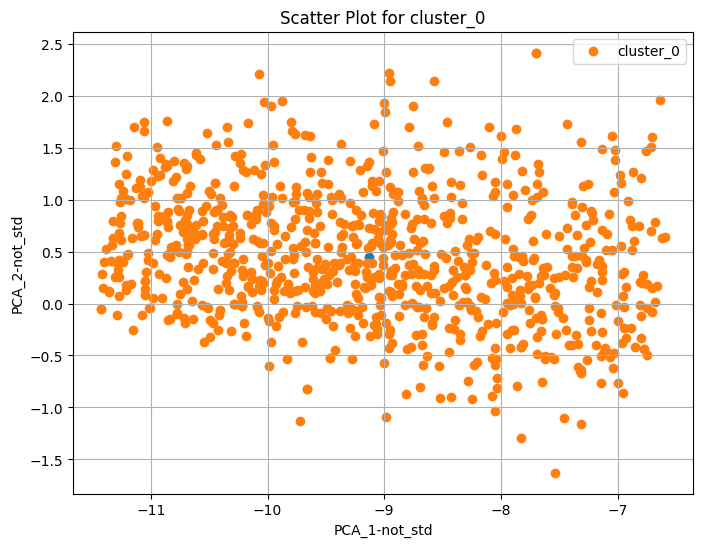

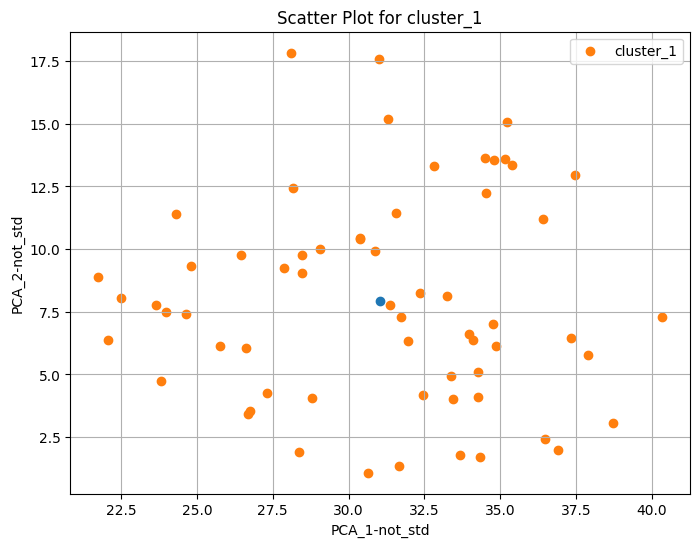

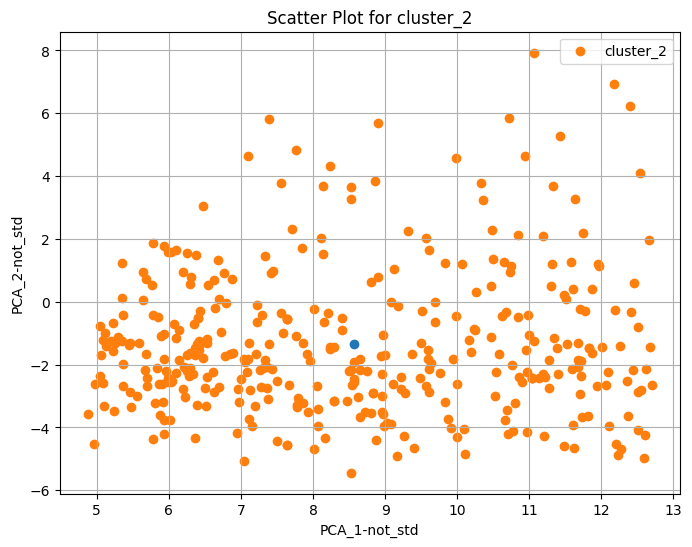

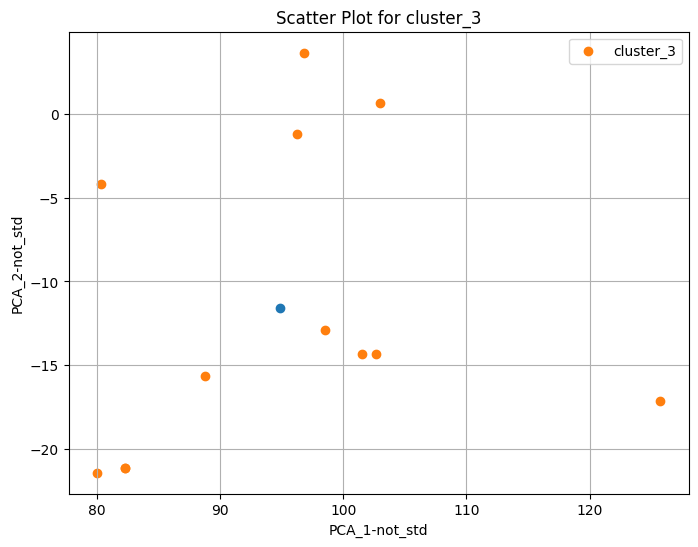

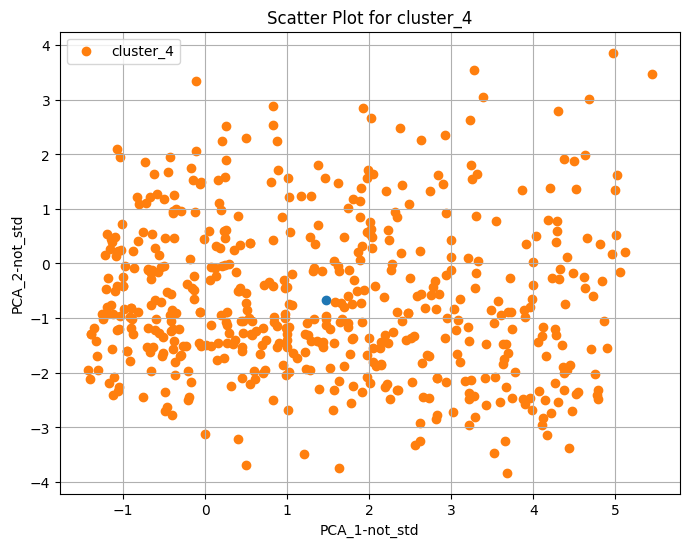

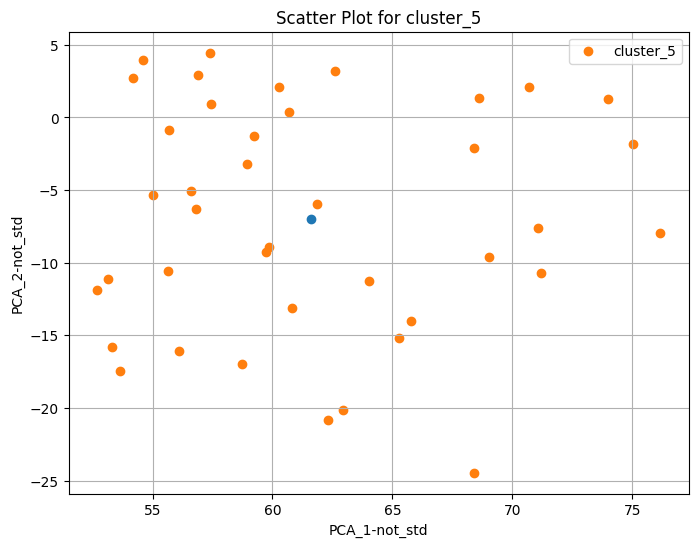

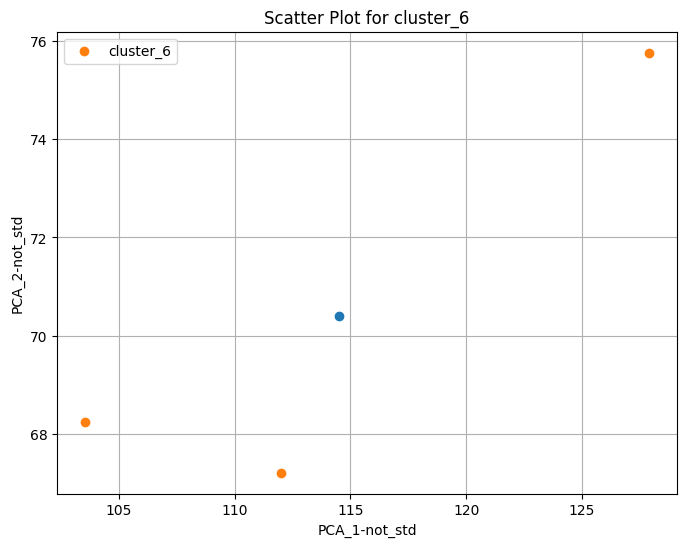

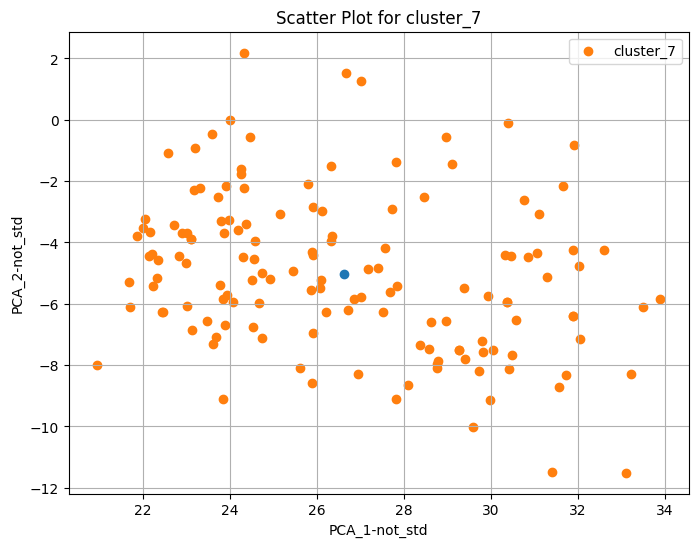

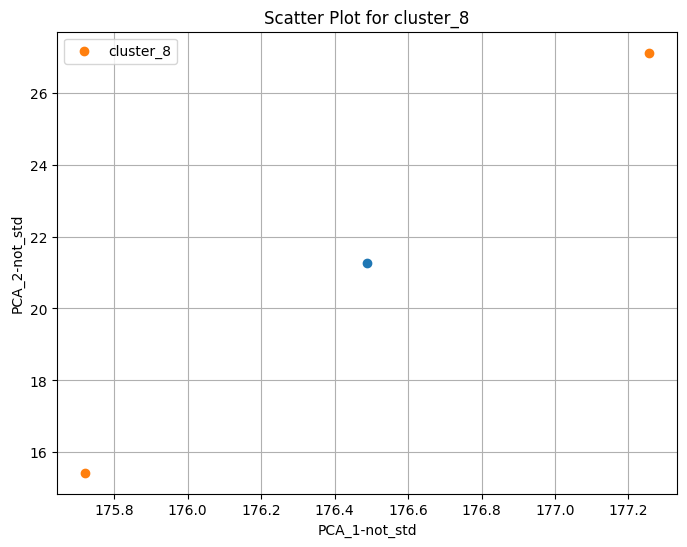

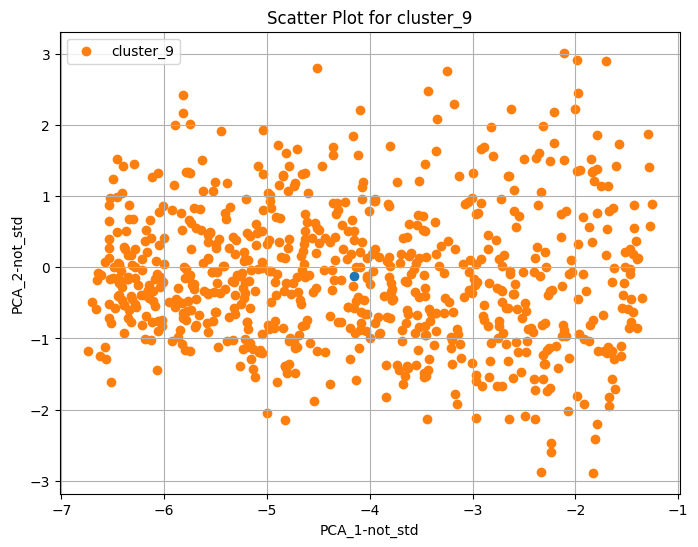

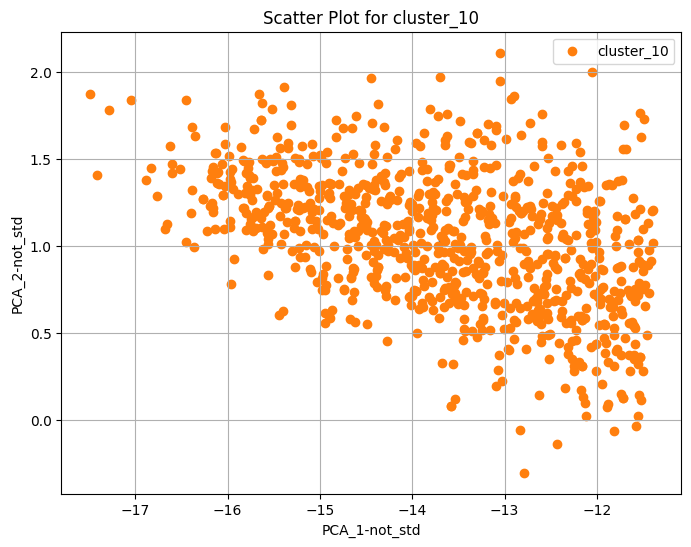

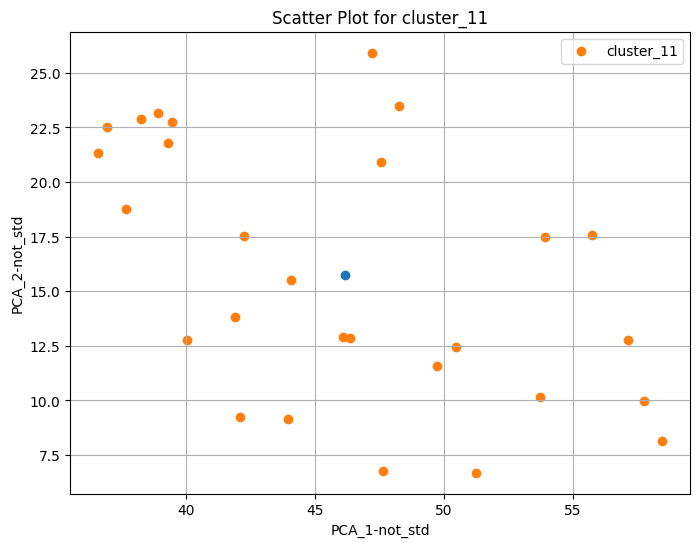

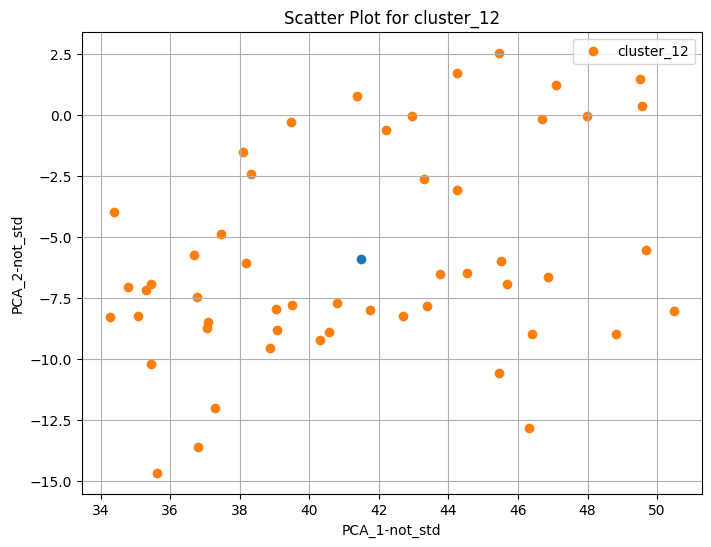

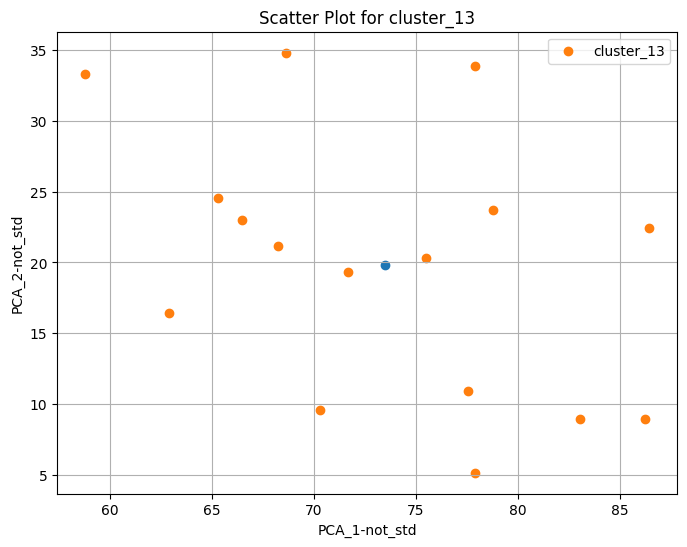

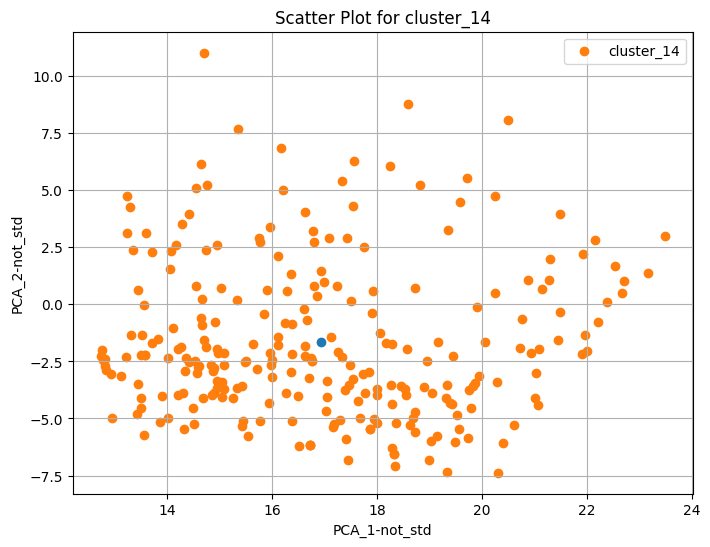

In [61]:
results_grouped =  results_df.groupby('cluster-std')
results_grouped

cluster_dfs = {}

# Loop through each group and create dataframes
for cluster, group_df in results_grouped:
    cluster_dfs[f'cluster_{cluster}'] = group_df[['Name', 'PCA_1-std', 'PCA_2-std']]

for cluster_key, cluster_df in cluster_dfs.items():  # cluster_name, dataframe for each cluster in all clusters: 
    cluster_index = int(cluster_key.split('_')[1])
    plt.figure(figsize=(8, 6))
    plt.scatter(centroids_std[cluster_index][0], centroids_std[cluster_index][1])
    plt.scatter(cluster_df['PCA_1-std'], cluster_df['PCA_2-std'], label=cluster_key)
    plt.xlabel('PCA_1-not_std')
    plt.ylabel('PCA_2-not_std')
    plt.title(f'Scatter Plot for {cluster_key}')
    plt.legend()
    plt.grid(True)
plt.show()

In [59]:
centroids_name = {}
for i, (x,y) in enumerate(centroids_std):
    print(x)

results_df[np.isclose(results_df['PCA_1-std'], -7.389605)]

-9.131675582318552
31.036751667143797
8.57078933804941
94.85600806552614
1.4754461799764627
61.61886744900071
114.48684528363204
26.63704344661034
176.48859103597135
-4.156301080565745
-13.663342180898296
46.17128119440625
41.49547555861311
73.49203650851706
16.93224278799166


,Name,PCA_1-std,PCA_2-std,cluster-std
0,HMDB0000058,-7.389605,0.973728,0
